In [14]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install torch.nn
!pip install torch.optim
!pip install matplotlib
!pip install pyspectra
!pip install PyWavelets
!pip install Seaborn
!pip install scikit-learn



ERROR: Could not find a version that satisfies the requirement torch.nn (from versions: none)
ERROR: No matching distribution found for torch.nn


In [ ]:
# seg1
# ÂÆö‰πâÊï∞ÊçÆÂ¢ûÂº∫ÂáΩÊï∞
def augment_data(spectrum, noise_level=0.01):
    """
    ÂØπÂÖâË∞±Êï∞ÊçÆÊ∑ªÂä†È´òÊñØÂô™Â£∞ËøõË°åÊï∞ÊçÆÂ¢ûÂº∫„ÄÇ
    spectrum: numpy array, shape: (2, seq_len)
    """
    noisy_spectrum = spectrum.copy()
    # ‰ªÖÂØπÂº∫Â∫¶ÈÄöÈÅìÊ∑ªÂä†Âô™Â£∞ÔºàÁ¥¢Âºï‰∏∫1Ôºâ
    noise = np.random.normal(0, noise_level, size=noisy_spectrum[1].shape)
    noisy_spectrum[1] += noise
    return noisy_spectrum

In [ ]:
# seg2
# ÂØºÂÖ•ÂøÖË¶ÅÁöÑÊ®°Âùó
import os
import re
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ÂØºÂÖ•ËØªÂèñ .spc Êñá‰ª∂ÁöÑÂáΩÊï∞
from pyspectra.readers.read_spc import read_spc

# ÂØºÂÖ•Â∞èÊ≥¢ÂèòÊç¢Â∫ì
import pywt

# ËÆæÁΩÆËÆæÂ§á
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Êï∞ÊçÆË∑ØÂæÑÂíåÂ§ÑÁêÜ
data_dirs = [
    'remix_data',
    'remix_data_2',
    'remix_data_3'
    # ÂèØ‰ª•Ê∑ªÂä†Êõ¥Â§öÁöÑË∑ØÂæÑ
]

# ÂÆö‰πâÂÖâË∞±Êï∞ÊçÆÈõÜÁ±ª
class SpectrumDataset(Dataset):
    def __init__(self, file_list, max_length=4096, augment=False):
        self.file_list = file_list
        self.max_length = max_length
        self.augment = augment
        self.data = []
        self.labels = []
        self.process_data()

    def process_data(self):
        for file_path in self.file_list:
            # ËØªÂèñ .spc Êàñ .asc Êñá‰ª∂
            if file_path.endswith('.spc'):
                spectrum = read_spc(file_path)
                wavelengths = spectrum.index.values
                intensities = spectrum.values.flatten()
            elif file_path.endswith('.asc'):
                data = pd.read_csv(file_path, sep='\t', header=None)
                wavelengths = data[0].values
                intensities = data[1].values

            # ÊèíÂÄºÂà∞Âõ∫ÂÆöÈïøÂ∫¶
            x_new = np.linspace(wavelengths.min(), wavelengths.max(), self.max_length)
            interpolated_intensities = np.interp(
                x_new,
                wavelengths,
                intensities
            )

            # Âº∫Â∫¶ÂΩí‰∏ÄÂåñÂà∞ [0, 1]
            normalized_intensities = (interpolated_intensities - interpolated_intensities.min()) / \
                                     (interpolated_intensities.max() - interpolated_intensities.min())

            # Ê≥¢ÈïøÂΩí‰∏ÄÂåñÂà∞ [0, 1]
            normalized_wavelengths = (x_new - x_new.min()) / (x_new.max() - x_new.min())

            # ÁªÑÂêàÊ≥¢ÈïøÂíåÂº∫Â∫¶ÔºåÂΩ¢Áä∂‰∏∫ (2, max_length)
            sample = np.stack([normalized_wavelengths, normalized_intensities], axis=0)

            # Êï∞ÊçÆÂ¢ûÂº∫
            if self.augment:
                sample = augment_data(sample)

            # Ëß£ÊûêÊ†áÁ≠æ
            label = self.parse_label(os.path.basename(file_path))

            # Â∞ÜÂ§ÑÁêÜÂêéÁöÑÊï∞ÊçÆÂíåÊ†áÁ≠æÊ∑ªÂä†Âà∞ÂàóË°®
            self.data.append(sample)
            self.labels.append(label)

        # Â∞ÜÊï∞ÊçÆËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑ
        self.data = np.array(self.data)  # shape: (num_samples, 2, max_length)
        self.labels = np.array(self.labels)

    def parse_label(self, filename):
        # ‰ªéÊñá‰ª∂Âêç‰∏≠ÊèêÂèñÊàêÂàÜÂíåÊØî‰æãÔºåÂÖºÂÆπÊï∞Â≠óÂíåÁΩóÈ©¨Êï∞Â≠óÊ†ºÂºè
        # Á§∫‰æãÊñá‰ª∂Âêç: "III+IV(1ÊØî1)-1300-1s10a-10%-4.asc"
        # Êàñ "1+4(33%ÊØî66%)-1s10a-10%-6.spc"

        # ÂÆö‰πâÁΩóÈ©¨Êï∞Â≠ó‰∏éÊï¥Êï∞ÁöÑÂØπÂ∫îÂÖ≥Á≥ª
        roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
        # ÂêàÂπ∂ÁΩóÈ©¨Êï∞Â≠óÂíåÈòøÊãâ‰ºØÊï∞Â≠óÁöÑÊ≠£ÂàôË°®ËææÂºè
        components_match = re.search(r'([IVX]+\+?[IVX]*|\d+\+?\d*)\((.*?)\)', filename)
        if components_match:
            components_str = components_match.group(1)
            ratios_str = components_match.group(2)

            # Â§ÑÁêÜÊàêÂàÜ
            components = components_str.split('+')
            parsed_components = []
            for comp in components:
                comp = comp.strip()
                if comp.isdigit():
                    parsed_components.append(int(comp))
                elif comp in roman_to_int:
                    parsed_components.append(roman_to_int[comp])
                else:
                    #print(f"Êú™Áü•ÁöÑÊàêÂàÜÊ†ºÂºèÔºö{comp}")
                    parsed_components.append(0)

            # Â§ÑÁêÜÊØî‰æã
            ratios = ratios_str.split('ÊØî')
            ratios = [r.strip('%') for r in ratios]
            ratios = [float(r) if r else 0 for r in ratios]

            # Â¶ÇÊûúÊØî‰æã‰∏≠ÂåÖÂê´ÁôæÂàÜÊØîÔºåËΩ¨Êç¢‰∏∫ÂÆûÈôÖÊØî‰æã
            if any('%' in ratios_str for r in ratios_str.split('ÊØî')):
                ratios = [r / 100 for r in ratios]
            else:
                total_ratio = sum(ratios)
                if total_ratio != 0:
                    ratios = [r / total_ratio for r in ratios]
                else:
                    ratios = [0 for r in ratios]
        else:
            # Â¶ÇÊûúÊó†Ê≥ïÂåπÈÖçÔºåËøîÂõûÈõ∂ÂêëÈáè
            parsed_components = []
            ratios = []

        # Âª∫Á´ãÊ†áÁ≠æÂêëÈáèÔºåÂõõ‰∏™Ëãè‰∏πÁ∫¢ÊàêÂàÜ
        label = np.zeros(4)
        for comp, ratio in zip(parsed_components, ratios):
            if 1 <= comp <= 4:
                index = comp - 1  # ÊàêÂàÜÁºñÂè∑‰ªé 1 ÂºÄÂßã
                label[index] = ratio
            else:
                #print(f"Êú™Áü•ÁöÑÊàêÂàÜÁºñÂè∑Ôºö{comp}")
                continue
                

        # Á°Æ‰øùÊØî‰æãÊÄªÂíå‰∏∫ 1
        if label.sum() != 0:
            label = label / label.sum()

        return label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrum = self.data[idx]  # shape: (2, max_length)
        label = self.labels[idx]
        return torch.tensor(spectrum, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)




In [ ]:
#seg3
# Êî∂ÈõÜÊâÄÊúâË∑ØÂæÑ‰∏≠ÁöÑÊñá‰ª∂
file_list = []
for data_dir in data_dirs:
    file_list.extend(glob.glob(os.path.join(data_dir, '*.spc')))
    file_list.extend(glob.glob(os.path.join(data_dir, '*.asc')))

# ËºâÂÖ•Êï∏ÊìöÈõÜ
dataset = SpectrumDataset(file_list, max_length=4096, augment=False)

# Ê™¢Êü•Êï∏ÊìöÂ§ßÂ∞è
print(f"‚úÖ Êï∏ÊìöÈõÜÂ§ßÂ∞è: {len(dataset)} Á≠ÜÊï∏Êìö")

# ËÆÄÂèñÁ¨¨‰∏ÄÁ≠ÜÊï∏Êìö
spectrum, label = dataset[0]

print("üìä Á¨¨‰∏ÄÁ≠ÜÊï∏Êìö (spectrum) ÂΩ¢ÁãÄ:", spectrum.shape)  # ÊáâË©≤ÊòØ (2, 4096)
print("üõ†Ô∏è Á¨¨‰∏ÄÁ≠ÜÊï∏Êìö (label):", label)  # ÈÄôÊòØË©≤Ê®£Êú¨ÁöÑÊ®ôÁ±§

gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


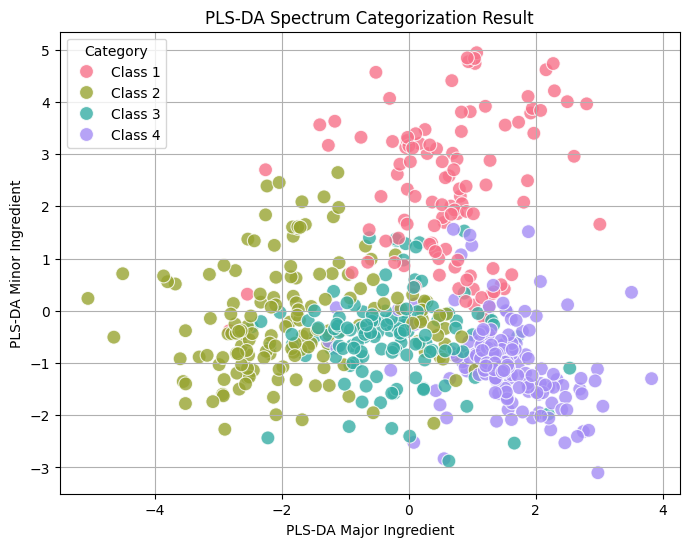

PLS-DA Ê∏¨Ë©¶ÈõÜÂàÜÈ°ûÊ∫ñÁ¢∫Â∫¶: 0.86
PLS-DA ‰∫§ÂèâÈ©óË≠âÊúÄ‰Ω≥Ê∫ñÁ¢∫Â∫¶: 0.80


In [ ]:
# seg4
# PLS-DA + Cross Validation
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# ‚úÖ ÂÅáË®≠ SpectrumDataset Â∑≤Á∂ìÊ≠£Á¢∫Âä†Ëºâ
dataset = SpectrumDataset(file_list, max_length=4096, augment=False)

# -------------------------------
# üõ†Ô∏è Step 1: ÊèêÂèñÂÖâË≠úÊï∏ÊìöËàáÊ®ôÁ±§
# -------------------------------
X = np.array([sample[0].numpy().flatten() for sample in dataset])  # shape: (num_samples, num_features)
y = np.array([sample[1].numpy() for sample in dataset])  # shape: (num_samples, num_classes)

# Á¢∫‰øù y ËΩâÊèõÁÇ∫Êï∏Â≠óÊ®ôÁ±§
y_numeric = np.argmax(y, axis=1)  # shape: (num_samples,)

# Á¢∫Ë™çÊï∏ÊìöÂΩ¢ÁãÄ
print(f"‚úÖ X shape (ÊáâË©≤ÊòØ 2D): {X.shape}")  # (num_samples, num_features)
print(f"‚úÖ y shape (ÊáâË©≤ÊòØ 1D): {y_numeric.shape}")  # (num_samples,)

# -------------------------------
# üîÑ Step 2: Ê®ôÊ∫ñÂåñÊï∏Êìö
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Á¢∫‰øùÊï∏ÊìöÂùáÂÄºÁÇ∫ 0ÔºåÊ®ôÊ∫ñÂ∑ÆÁÇ∫ 1

# -------------------------------
# üîÑ Step 3: ‰∫§ÂèâÈ©óË≠âÈÅ∏ÊìáÊúÄ‰Ω≥ PLS ‰∏ªÊàêÂàÜÊï∏
# -------------------------------
best_score = 0
best_n_components = 0
cv_scores = []

# PLS ÊàêÂàÜÊï∏‰∏çËÉΩË∂ÖÈÅéÁâπÂæµÊï∏
max_components = min(15, X.shape[1])

# ‰ΩøÁî® 5-Fold Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(2, max_components):  # Ê∏¨Ë©¶ n_components Âæû 2 Âà∞ max_components
    pls = PLSRegression(n_components=n)
    
    # Ë®ìÁ∑¥ PLS ‰∏¶Á¢∫‰øù X_scores ÊòØ 2D
    X_scores = pls.fit_transform(X_scaled, y)[0]  # ÂèñÁ¨¨‰∏ÄÂÄãËº∏Âá∫ÔºåÁ¢∫‰øùÊòØ 2D
    print(f"PLS components {n}: X_scores shape {X_scores.shape}")  # Debugging

    # ‰∫§ÂèâÈ©óË≠â
    scores = cross_val_score(LDA(), X_scores, y_numeric, cv=skf, scoring="accuracy")
    avg_score = scores.mean()
    cv_scores.append((n, avg_score))

    print(f"PLS components: {n}, CV Accuracy: {avg_score:.2f}")

    if avg_score > best_score:
        best_score = avg_score
        best_n_components = n

print(f"‚úÖ ÊúÄ‰Ω≥ PLS ‰∏ªÊàêÂàÜÊï∏: {best_n_components}, ‰∫§ÂèâÈ©óË≠âÊ∫ñÁ¢∫Â∫¶: {best_score:.2f}")

# -------------------------------
# üî¢ Step 4: ‰ΩøÁî®ÊúÄ‰Ω≥ PLS Ë®ìÁ∑¥ PLS-DA
# -------------------------------
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_scaled, y)  # y ÊòØ one-hot Ê®ôÁ±§Áü©Èô£

# ÊäïÂΩ±Âà∞ PLS ÊΩõÂú®ËÆäÊï∏Á©∫Èñì
X_scores = pls.x_scores_

# -------------------------------
# üîç Step 5: LDA Âú® PLS ÂàÜÊï∏Á©∫Èñì‰∏≠ÂàÜÈ°û
# -------------------------------
lda = LDA()
X_lda = lda.fit_transform(X_scores, y_numeric)

# üîÑ ‰øÆÊîπÊ®ôÁ±§Ôºå‰ΩøÈ°ûÂà•Âæû 1 ÈñãÂßã
y_numeric_plot = y_numeric + 1  # ËÆìÊ®ôÁ±§Âæû 1 ÈñãÂßãÔºåËÄåÈùû 0

# üîπ ÈÅ∏ÊìáÂêàÈÅ©ÁöÑË™øËâ≤Áõ§
num_classes = len(np.unique(y_numeric_plot))
palette = sns.color_palette("husl", num_classes)  # Ëá™ÂãïÁîüÊàê‰∏çÂêåÈ°èËâ≤

# -------------------------------
# üìä Step 6: ÂèØË¶ñÂåñ PLS-DA ÁµêÊûú
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y_numeric_plot, palette=palette, s=100, alpha=0.8)
plt.xlabel("PLS-DA Major Ingredient")
plt.ylabel("PLS-DA Minor Ingredient")
plt.title("PLS-DA Spectrum Categorization Result")

# üîπ Á¢∫‰øùÂúñ‰æãÈ°ØÁ§∫ Class 1, Class 2, ...
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f"Class {int(l)}" for l in labels]
plt.legend(handles=handles, labels=new_labels, title="Category")

plt.grid(True)
plt.show()

# -------------------------------
# üèÜ Step 7: Ë®ìÁ∑¥-Ê∏¨Ë©¶ÈõÜÂäÉÂàÜÔºåË©ï‰º∞ÂàÜÈ°ûÊ∫ñÁ¢∫Â∫¶
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_numeric, test_size=0.2, random_state=42)

# Ë®ìÁ∑¥ LDA ÂàÜÈ°ûÂô®
lda_classifier = LDA()
lda_classifier.fit(X_train, y_train)
y_pred = lda_classifier.predict(X_test)

# Ë®àÁÆóÂàÜÈ°ûÊ∫ñÁ¢∫Â∫¶
test_accuracy = accuracy_score(y_test, y_pred)
print(f"PLS-DA Ê∏¨Ë©¶ÈõÜÂàÜÈ°ûÊ∫ñÁ¢∫Â∫¶: {test_accuracy:.2f}")
print(f"PLS-DA ‰∫§ÂèâÈ©óË≠âÊúÄ‰Ω≥Ê∫ñÁ¢∫Â∫¶: {best_score:.2f}")



In [ ]:
# seg5
# PLS-DA + Cross Validation + VIP + Áî®VIPÁúãËÉΩ‰∏çËÉΩÊïàÊûúÊõ¥Â•Ω Áî®Âú®‰∏çÂêåÊâπÊ¨°
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# ‚úÖ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ‚úÖ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ‚úÖ Store results
results_before_vip = []
results_after_vip = []

# ‚úÖ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

# ‚úÖ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\nüöÄ Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ‚úÖ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"‚úÖ Training set size: {len(train_dataset)} samples")
    print(f"‚úÖ Testing set size: {len(test_dataset)} samples")

    # ‚úÖ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ‚úÖ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ‚úÖ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # üîÑ Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"‚úÖ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # üî¢ Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"üéØ Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # -------------------------------
    # üìä Step 3: Select Features Using VIP (Only VIP > 9)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]  # Select features with VIP > 1
    print(f"üîç Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # üî¢ Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"üéØ Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")


# üî• Compute Average Accuracies
avg_before_vip = np.mean([res[1] for res in results_before_vip])
avg_after_vip = np.mean([res[1] for res in results_after_vip])

print("\nüìä Test Results Before VIP Selection:")
for test_dir, acc in results_before_vip:
    print(f"üìÇ Test Set: {test_dir} -> Accuracy: {acc:.2f}")

print("\nüìä Test Results After VIP Selection:")
for test_dir, acc in results_after_vip:
    print(f"üìÇ Test Set: {test_dir} -> Accuracy: {acc:.2f}")

print(f"\n‚úÖ Average Test Accuracy Before VIP: {avg_before_vip:.2f}")
print(f"‚úÖ Average Test Accuracy After VIP: {avg_after_vip:.2f}")



üöÄ Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(

In [ ]:
# seg6
# PLS-DA + Cross Validation + VIP + Hamming Accuracy + batches

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# sys.stdout = open('output.txt', 'w')  # ÊääÊâÄÊúâËº∏Âá∫ÂØ´ÂÖ•Ê™îÊ°à

# ‚úÖ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ‚úÖ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ‚úÖ Store results
results_before_vip = []
results_after_vip = []
hamming_results_before_vip = []
hamming_results_after_vip = []

# ‚úÖ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

def hamming_accuracy(y_true, y_pred):
    """ Compute Hamming Accuracy for multi-label classification """
    return 1 - np.mean(np.abs(y_true - y_pred))

# ‚úÖ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\nüöÄ Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ‚úÖ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"‚úÖ Training set size: {len(train_dataset)} samples")
    print(f"‚úÖ Testing set size: {len(test_dataset)} samples")

    # ‚úÖ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ‚úÖ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ‚úÖ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # üîÑ Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"‚úÖ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # üî¢ Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"üéØ Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # ‚úÖ Compute Initial Hamming Accuracy
    test_accuracy_hamming_before = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred])
    hamming_results_before_vip.append((test_dir, test_accuracy_hamming_before))
    print(f"üéØ Initial Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_before:.2f}")

    # -------------------------------
    # üìä Step 3: Select Features Using VIP (Only VIP > 3)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]
    print(f"üîç Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # üî¢ Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"üéØ Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")

    # ‚úÖ Compute Hamming Accuracy After VIP
    test_accuracy_hamming_after = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred_vip])
    hamming_results_after_vip.append((test_dir, test_accuracy_hamming_after))
    print(f"üéØ Optimized Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_after:.2f}")

# üî• Compute Average Accuracies
avg_hamming_before_vip = np.mean([res[1] for res in hamming_results_before_vip])
avg_hamming_after_vip = np.mean([res[1] for res in hamming_results_after_vip])

print(f"\n‚úÖ Average Hamming Accuracy Before VIP: {avg_hamming_before_vip:.2f}")
print(f"‚úÖ Average Hamming Accuracy After VIP: {avg_hamming_after_vip:.2f}")

# sys.stdout.close()
# sys.stdout = sys.__stdout__  # ÊÅ¢Âæ©Ê≠£Â∏∏Ëº∏Âá∫

# # ËÆÄÂèñÊ™îÊ°à‰∏¶ÂÆåÊï¥È°ØÁ§∫
# with open('output.txt', 'r') as f:
#     print(f.read())



üöÄ Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(

In [ ]:
# seg7
# PLS-DA + Cross Validation + VIP + Hamming Accuracy + batches

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# sys.stdout = open('output.txt', 'w')  # ÊääÊâÄÊúâËº∏Âá∫ÂØ´ÂÖ•Ê™îÊ°à

# ‚úÖ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ‚úÖ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ‚úÖ Store results
results_before_vip = []
results_after_vip = []
hamming_results_before_vip = []
hamming_results_after_vip = []

# ‚úÖ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

def hamming_accuracy(y_true, y_pred):
    """ Compute Hamming Accuracy for multi-label classification """
    return 1 - np.mean(np.abs(y_true - y_pred))

# ‚úÖ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\nüöÄ Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ‚úÖ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"‚úÖ Training set size: {len(train_dataset)} samples")
    print(f"‚úÖ Testing set size: {len(test_dataset)} samples")

    # ‚úÖ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ‚úÖ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ‚úÖ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # üîÑ Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"‚úÖ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # üî¢ Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"üéØ Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # ‚úÖ Compute Initial Hamming Accuracy
    test_accuracy_hamming_before = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred])
    hamming_results_before_vip.append((test_dir, test_accuracy_hamming_before))
    print(f"üéØ Initial Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_before:.2f}")

    # -------------------------------
    # üìä Step 3: Select Features Using VIP (Only VIP > 3)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]
    print(f"üîç Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # üî¢ Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"üéØ Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")

    # ‚úÖ Compute Hamming Accuracy After VIP
    test_accuracy_hamming_after = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred_vip])
    hamming_results_after_vip.append((test_dir, test_accuracy_hamming_after))
    print(f"üéØ Optimized Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_after:.2f}")

# üî• Compute Average Accuracies
avg_hamming_before_vip = np.mean([res[1] for res in hamming_results_before_vip])
avg_hamming_after_vip = np.mean([res[1] for res in hamming_results_after_vip])

print(f"\n‚úÖ Average Hamming Accuracy Before VIP: {avg_hamming_before_vip:.2f}")
print(f"‚úÖ Average Hamming Accuracy After VIP: {avg_hamming_after_vip:.2f}")

# sys.stdout.close()
# sys.stdout = sys.__stdout__  # ÊÅ¢Âæ©Ê≠£Â∏∏Ëº∏Âá∫

# # ËÆÄÂèñÊ™îÊ°à‰∏¶ÂÆåÊï¥È°ØÁ§∫
# with open('output.txt', 'r') as f:
#     print(f.read())


üöÄ Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(

gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


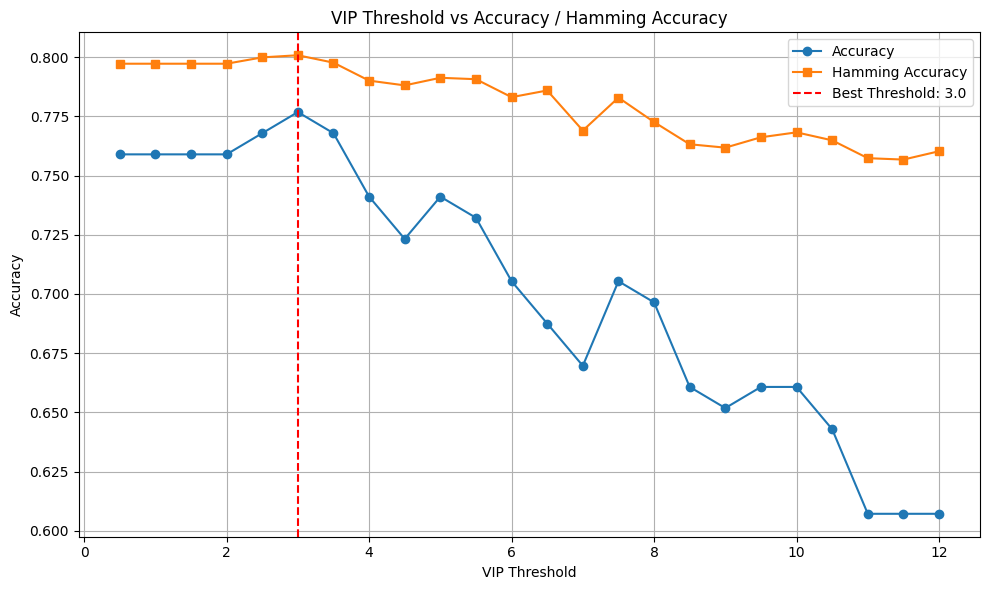

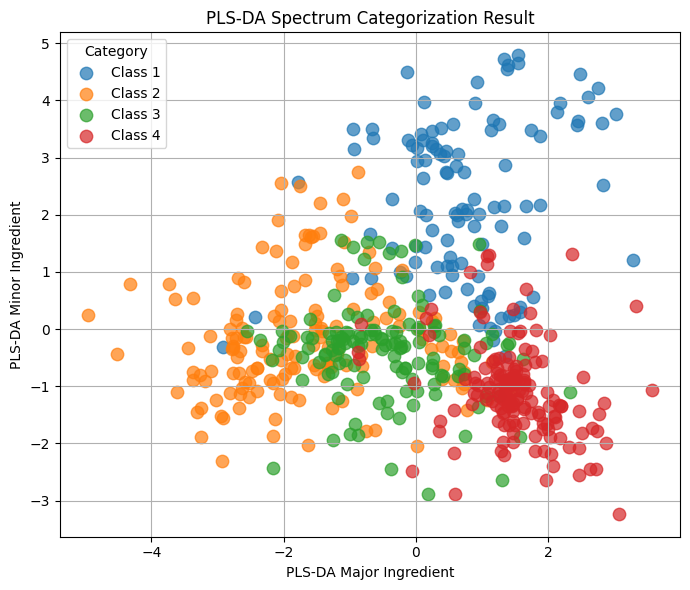

'\n# -------------------------------\n# üß™ Ê®ôË®òÊúÄ‰Ω≥ÁâπÂæµÁöÑÊ≥¢Èï∑‰ΩçÁΩÆ\n# -------------------------------\nwavelength_features = best_features[best_features < 4096]\nintensity_features = best_features[best_features >= 4096] - 4096\n\nwavelengths = dataset[0][0][0].numpy()\n\nplt.figure(figsize=(14, 4))\nplt.plot(wavelengths, label=\'Normalized Wavelength\')\nplt.scatter(wavelengths[wavelength_features], np.ones(len(wavelength_features))*1.05, \n            color=\'blue\', label=\'Wavelength Features\', marker=\'|\', s=80)\nplt.scatter(wavelengths[intensity_features], np.ones(len(intensity_features))*0.95, \n            color=\'red\', label=\'Intensity Features\', marker=\'|\', s=80)\nplt.title(f"VIP Selected Features (Threshold = {best_threshold:.1f})")\nplt.xlabel("Normalized Wavelength")\nplt.ylabel("Marker")\nplt.ylim(0.9, 1.1)\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# seg8
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

# ‚úÖ ËºîÂä©ÂáΩÂºè
def hamming_accuracy(y_true, y_pred):
    return 1 - np.mean(np.abs(y_true - y_pred))

def calculate_vip(pls):
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T)**2 * weight_sum) / np.sum((T @ Q.T)**2))
    return vip_scores

# ‚úÖ Ë≥áÊñôË∑ØÂæë
data_dirs = ['remix_data', 'remix_data_2', 'remix_data_3']
all_files = []
for d in data_dirs:
    all_files.extend(glob.glob(os.path.join(d, '*.*')))

# ‚úÖ ËºâÂÖ•Ë≥áÊñô
dataset = SpectrumDataset(all_files, max_length=4096, augment=False)

X = np.array([sample[0].numpy().flatten() for sample in dataset])
y = np.array([sample[1].numpy() for sample in dataset])
y_numeric = np.argmax(y, axis=1)

# ‚úÖ Train/Test split
X_train, X_test, y_train, y_test, y_train_numeric, y_test_numeric = train_test_split(
    X, y, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# ‚úÖ Ê®ôÊ∫ñÂåñ
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ‚úÖ PLS ‰∏ªÊàêÂàÜÈÅ∏Êìá
best_score = 0
best_n_components = 0
max_components = min(15, X_train_scaled.shape[1])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(2, max_components):
    pls = PLSRegression(n_components=n)
    X_scores = pls.fit_transform(X_train_scaled, y_train)[0]
    scores = []
    for train_idx, val_idx in skf.split(X_scores, y_train_numeric):
        lda = LDA()
        lda.fit(X_scores[train_idx], y_train_numeric[train_idx])
        val_pred = lda.predict(X_scores[val_idx])
        scores.append(accuracy_score(y_train_numeric[val_idx], val_pred))
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_n_components = n

print(f"‚úÖ ÊúÄ‰Ω≥ PLS ‰∏ªÊàêÂàÜÊï∏: {best_n_components}, CV Accuracy: {best_score:.2f}")

# ‚úÖ Ë®ìÁ∑¥ÊúÄÁµÇÊ®°Âûã‰∏¶Ë®àÁÆó VIP ÂàÜÊï∏
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_train_scaled, y_train)
vip_scores = calculate_vip(pls)

# ‚úÖ VIP ÈñÄÊ™ª Grid Search + Ë©ï‰º∞
threshold_range = np.arange(0.5, 12.5, 0.5)
acc_list = []
hamming_list = []
best_acc = 0
best_threshold = None
best_features = None

for threshold in threshold_range:
    important_features = np.where(vip_scores > threshold)[0]
    if len(important_features) < best_n_components:
        acc_list.append(np.nan)
        hamming_list.append(np.nan)
        continue

    # ÈÅ∏ÊìáÈáçË¶ÅÁâπÂæµÂæåÈáçÊñ∞Ê®ôÊ∫ñÂåñ
    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]
    scaler_vip = StandardScaler()
    X_train_vip = scaler_vip.fit_transform(X_train_vip)
    X_test_vip = scaler_vip.transform(X_test_vip)

    # PLS + LDA Ë®ìÁ∑¥
    pls_vip = PLSRegression(n_components=best_n_components)
    pls_vip.fit(X_train_vip, y_train)
    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    lda_vip.fit(X_train_scores_vip, y_train_numeric)
    y_pred_vip = lda_vip.predict(X_test_scores_vip)

    acc = accuracy_score(y_test_numeric, y_pred_vip)
    hamm = hamming_accuracy(y_test, np.eye(y.shape[1])[y_pred_vip])
    acc_list.append(acc)
    hamming_list.append(hamm)

    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold
        best_features = important_features

print(f"\nüéØ ÊúÄ‰Ω≥ VIP ÈñÄÊ™ª: {best_threshold:.1f}")
print(f"   Accuracy: {best_acc:.3f}")
print(f"   Hamming Accuracy: {hamming_list[np.argmax(acc_list)]:.3f}")
print(f"   Selected Features: {len(best_features)}")

# -------------------------------
# üìà Áï´ÂúñÔºöVIP ÈñÄÊ™ª vs Accuracy & Hamming Accuracy
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, acc_list, label='Accuracy', marker='o')
plt.plot(threshold_range, hamming_list, label='Hamming Accuracy', marker='s')
plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold: {best_threshold:.1f}')
plt.xlabel("VIP Threshold")
plt.ylabel("Accuracy")
plt.title("VIP Threshold vs Accuracy / Hamming Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# üìà PLS-DA 2D Scatter Plot of Final Result
# -------------------------------
from matplotlib import cm

# ÊúÄ‰Ω≥Ê®°ÂûãÊäïÂΩ±ÂæåÁöÑË≥áÊñôÈªûÔºà‰ª• VIP + LDA ÁÇ∫‰æãÔºâ
X_all = np.vstack([X_train_scaled, X_test_scaled])
y_all_numeric = np.concatenate([y_train_numeric, y_test_numeric])

X_all_vip = X_all[:, best_features]
scaler_vip = StandardScaler()
X_all_vip = scaler_vip.fit_transform(X_all_vip)

pls_final = PLSRegression(n_components=best_n_components)
pls_final.fit(X_all_vip, np.vstack([y_train, y_test]))
X_all_scores = pls_final.transform(X_all_vip)

lda_final = LDA()
X_lda_final = lda_final.fit_transform(X_all_scores, y_all_numeric)

# -------------------------------
# üåà Plot
# -------------------------------
plt.figure(figsize=(7, 6))
num_classes = y.shape[1]
palette = sns.color_palette("husl", num_classes)

for class_idx in range(num_classes):
    indices = np.where(y_all_numeric == class_idx)[0]
    plt.scatter(X_lda_final[indices, 0],
                X_lda_final[indices, 1],
                label=f"Class {class_idx + 1}",
                alpha=0.7,
                s=80)

plt.xlabel("PLS-DA Major Ingredient")
plt.ylabel("PLS-DA Minor Ingredient")
plt.title("PLS-DA Spectrum Categorization Result")
plt.legend(title="Category")
plt.grid(True)
plt.tight_layout()
plt.show()


"""
# -------------------------------
# üß™ Ê®ôË®òÊúÄ‰Ω≥ÁâπÂæµÁöÑÊ≥¢Èï∑‰ΩçÁΩÆ
# -------------------------------
wavelength_features = best_features[best_features < 4096]
intensity_features = best_features[best_features >= 4096] - 4096

wavelengths = dataset[0][0][0].numpy()

plt.figure(figsize=(14, 4))
plt.plot(wavelengths, label='Normalized Wavelength')
plt.scatter(wavelengths[wavelength_features], np.ones(len(wavelength_features))*1.05, 
            color='blue', label='Wavelength Features', marker='|', s=80)
plt.scatter(wavelengths[intensity_features], np.ones(len(intensity_features))*0.95, 
            color='red', label='Intensity Features', marker='|', s=80)
plt.title(f"VIP Selected Features (Threshold = {best_threshold:.1f})")
plt.xlabel("Normalized Wavelength")
plt.ylabel("Marker")
plt.ylim(0.9, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""


